# **Part II: Linear Regression with Two Feature**

## **Objective**

Capture nonlinear and interaction effects using polynomial feature engineering and an explicit bias term:
$$
\hat{L} = X \cdot w + b
$$

## **Feature Map**

Construct the design matrix using the following features (do not include a constant column of ones):
$$
X = [ M, T, M^2, M \cdot T]
$$


# Required Tasks

1. **Dataset visualization:** plot L vs M and encode T (color or marker size).
2. **Feature engineering:** build X with NumPy vectorization.
3. **Loss and gradients (vectorized):** implement ME and gradients w.r.t. both w and b.
4. **Gradient descent + convergence:** train and plot loss vs iterations.
5. **Feature selection experiment (mandatory):** compare:
    * $$ M1: X = [M, T] $$
    * $$ M2: X = [M, T, M^2] $$
    * $$ M3: X = [M, T, M^2, M \cdot T] $$
    For each model: report final loss, learned parameters, and show predicted vs actual (inline plot).
6. **Cost vs interaction (mandatory):** for the full model (M3), vary the interaction coefficient w_MT across a reasonable range while keeping the other parameters fixed (e.g., at their trained values). Plot cost vs w_MT and explain what it indicates about interaction importance.
7. **Inference demo (mandatory):** predict luminosity for a new star (e.g., M=1.3, T=6600). Comment on reasonableness.

## 1. Dataset Visualitation
 **Dataset (two features):**\
**M:** stellar mass (in units of solar mass, M⊙)\
**T:** effective stellar temperature (Kelvin, K)
**L:** stellar luminosity (in units of solar luminosity, L⊙)
* **M** = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4]\ 
* **L** = [0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0]
* **T:** = [3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200]  

Plot L vs M and encode T using color or marker size.


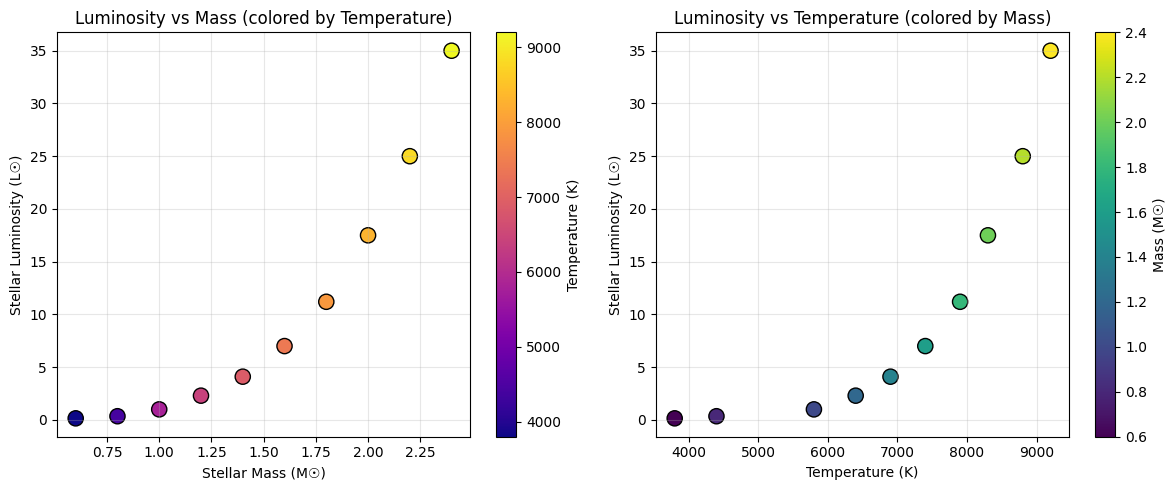

In [80]:
import numpy as np
import matplotlib.pyplot as plt

M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
T = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200])
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sc1 = plt.scatter(
    M, L,
    c=T,
    cmap='plasma',
    s=120,
    edgecolors='black'
)
plt.colorbar(sc1, label='Temperature (K)')
plt.xlabel("Stellar Mass (M☉)")
plt.ylabel("Stellar Luminosity (L☉)")
plt.title("Luminosity vs Mass (colored by Temperature)")
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
sc2 = plt.scatter(
    T, L,
    c=M,
    cmap='viridis',
    s=120,
    edgecolors='black'
)
plt.colorbar(sc2, label='Mass (M☉)')
plt.xlabel("Temperature (K)")
plt.ylabel("Stellar Luminosity (L☉)")
plt.title("Luminosity vs Temperature (colored by Mass)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 2. Feature engineering

Build X with NumPy vectorization.

In [81]:
def build_feature_matrix(M, T, model_type='M3'):
    if model_type == 'M1':
        X = np.column_stack([M, T])
        feature_names = ['M', 'T']
    
    elif model_type == 'M2':
        X = np.column_stack([M, T, M**2])
        feature_names = ['M', 'T', 'M²']
    
    elif model_type == 'M3':
        X = np.column_stack([M, T, M**2, M * T])
        feature_names = ['M', 'T', 'M²', 'M·T']
    
    else:
        raise ValueError(f"Unknown model_type: {model_type}. Use 'M1', 'M2', or 'M3'.")
    
    return X, feature_names


X_M1, features_M1 = build_feature_matrix(M, T, 'M1')
X_M2, features_M2 = build_feature_matrix(M, T, 'M2')
X_M3, features_M3 = build_feature_matrix(M, T, 'M3')

print("=" * 60)
print("Feature Engineering Results")

print(f"\nModel M1 - Features: {features_M1}")
print(f"  Shape: {X_M1.shape}")
print(f"  First 3 rows:\n{X_M1[:3]}")

print(f"\nModel M2 - Features: {features_M2}")
print(f"  Shape: {X_M2.shape}")
print(f"  First 3 rows:\n{X_M2[:3]}")

print(f"\nModel M3 - Features: {features_M3}")
print(f"  Shape: {X_M3.shape}")
print(f"  First 3 rows:\n{X_M3[:3]}")

Feature Engineering Results

Model M1 - Features: ['M', 'T']
  Shape: (10, 2)
  First 3 rows:
[[   0.6 3800. ]
 [   0.8 4400. ]
 [   1.  5800. ]]

Model M2 - Features: ['M', 'T', 'M²']
  Shape: (10, 3)
  First 3 rows:
[[   0.6  3800.      0.36]
 [   0.8  4400.      0.64]
 [   1.   5800.      1.  ]]

Model M3 - Features: ['M', 'T', 'M²', 'M·T']
  Shape: (10, 4)
  First 3 rows:
[[   0.6  3800.      0.36 2280.  ]
 [   0.8  4400.      0.64 3520.  ]
 [   1.   5800.      1.   5800.  ]]


In [82]:
def feature_scale(X):
    means = X.mean(axis=0)
    stds = X.std(axis=0, ddof=0)
    stds = np.where(stds == 0, 1, stds)
    X_scaled = (X - means) / stds
    return X_scaled, means, stds


X_M3_scaled, X_M3_means, X_M3_stds = feature_scale(X_M3)

print("Feature Scaling for Model M3:")
print(f"  Feature means: {X_M3_means}")
print(f"  Feature stds:  {X_M3_stds}")
print(f"\nScaled X_M3 (first 3 rows):\n{X_M3_scaled[:3]}")
print(f"\nVerification - Scaled means: {X_M3_scaled.mean(axis=0)}")
print(f"Verification - Scaled stds:  {X_M3_scaled.std(axis=0)}")

Feature Scaling for Model M3:
  Feature means: [    1.5   6890.       2.58 11304.  ]
  Feature stds:  [   0.57 1715.49    1.75 6371.91]

Scaled X_M3 (first 3 rows):
[[-1.57 -1.8  -1.27 -1.42]
 [-1.22 -1.45 -1.11 -1.22]
 [-0.87 -0.64 -0.9  -0.86]]

Verification - Scaled means: [-0.  0.  0.  0.]
Verification - Scaled stds:  [1. 1. 1. 1.]


## 3. Loss and gradients (vectorized)

Implement ME and gradients w.r.t. both w and b.

In [83]:
def predict(X, w, b):
    return X @ w + b


def compute_cost(X, L, w, b):
    m = X.shape[0]
    L_hat = predict(X, w, b)
    errors = L_hat - L
    cost = (errors @ errors) / (2 * m)
    return cost


def compute_gradients(X, L, w, b):
    m = X.shape[0]
    L_hat = predict(X, w, b)
    errors = L_hat - L
    
    dj_dw = (X.T @ errors) / m
    dj_db = np.sum(errors) / m
    
    return dj_dw, dj_db


print("Testing Loss and Gradient Functions")
print("=" * 60)

n_features = X_M3_scaled.shape[1]
w_test = np.zeros(n_features)
b_test = 0.0

L_pred_test = predict(X_M3_scaled, w_test, b_test)
print(f"\nTest predictions (first 5) with w=0, b=0: {L_pred_test[:5]}")

cost_test = compute_cost(X_M3_scaled, L, w_test, b_test)
print(f"Cost with w=0, b=0: {cost_test:.4f}")

dj_dw_test, dj_db_test = compute_gradients(X_M3_scaled, L, w_test, b_test)
print(f"\nGradients at w=0, b=0:")
print(f"  ∂J/∂w = {dj_dw_test}")
print(f"  ∂J/∂b = {dj_db_test:.4f}")

Testing Loss and Gradient Functions

Test predictions (first 5) with w=0, b=0: [0. 0. 0. 0. 0.]
Cost with w=0, b=0: 117.6967

Gradients at w=0, b=0:
  ∂J/∂w = [-10.42  -9.6  -10.99 -10.72]
  ∂J/∂b = -10.3600


## 4. Gradient descent + convergence

Train and plot loss vs iterations.

Training Polynomial Regression Model (M3)
Iteration     0: cost = 72.438211
Iteration   100: cost = 3.286783
Iteration   200: cost = 1.686453
Iteration   300: cost = 1.198722
Iteration   400: cost = 1.040189
Iteration   500: cost = 0.979338
Iteration   600: cost = 0.947745
Iteration   700: cost = 0.925177
Iteration   800: cost = 0.905646
Iteration   900: cost = 0.887370
Iteration   999: cost = 0.869987
Final cost: 0.869987
Learned weights: [-1.89 -7.86 13.9   6.39]
Learned bias: 10.3600


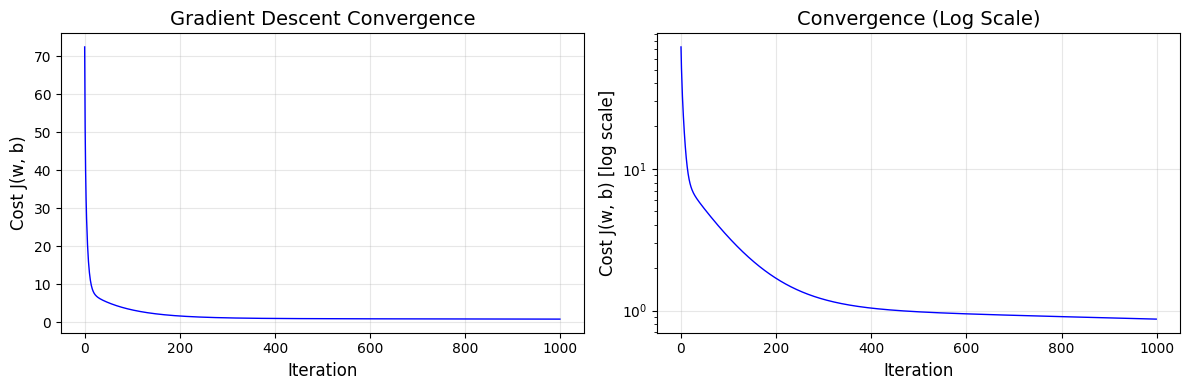

In [84]:
def gradient_descent(X, L, w_init, b_init, learning_rate, num_iterations, verbose=True):
    w = w_init.copy()
    b = b_init
    cost_history = []
    
    for i in range(num_iterations):
        dj_dw, dj_db = compute_gradients(X, L, w, b)
        
        w = w - learning_rate * dj_dw
        b = b - learning_rate * dj_db
        
        cost = compute_cost(X, L, w, b)
        cost_history.append(cost)
        
        if verbose and (i % max(1, num_iterations // 10) == 0 or i == num_iterations - 1):
            print(f"Iteration {i:5d}: cost = {cost:.6f}")
    
    return w, b, cost_history


print("Training Polynomial Regression Model (M3)")
print("=" * 60)

n_features = X_M3_scaled.shape[1]
w_init = np.zeros(n_features)
b_init = 0.0

learning_rate = 0.1
num_iterations = 1000

w_M3, b_M3, cost_history_M3 = gradient_descent(
    X_M3_scaled, L, w_init, b_init, learning_rate, num_iterations
)


print(f"Final cost: {cost_history_M3[-1]:.6f}")
print(f"Learned weights: {w_M3}")
print(f"Learned bias: {b_M3:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cost_history_M3, 'b-', linewidth=1)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Cost J(w, b)", fontsize=12)
plt.title("Gradient Descent Convergence", fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(cost_history_M3, 'b-', linewidth=1)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Cost J(w, b) [log scale]", fontsize=12)
plt.title("Convergence (Log Scale)", fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## 5. Feature selection experiment (mandatory)

For each model: report final loss, learned parameters, and show predicted vs actual (inline plot).

FEATURE SELECTION EXPERIMENT: Comparing M1, M2, M3 Models

MODEL M1: Features = [M, T]
Final cost: 3.904740
Learned weights: [ 24.91 -14.82]
Learned bias: 10.3600

MODEL M2: Features = [M, T, M²]
Final cost: 0.876212
Learned weights: [ 0.19 -7.09 17.47]
Learned bias: 10.3600

MODEL M3: Features = [M, T, M², M·T]
Final cost: 0.869987
Learned weights: [-1.89 -7.86 13.9   6.39]
Learned bias: 10.3600
MODEL COMPARISON
Model      Features                  Final Cost      Improvement    
M1         [M, T]                    3.904740        ---            
M2         [M, T, M²]                0.876212        77.6%          
M3         [M, T, M², M·T]           0.869987        77.7%          


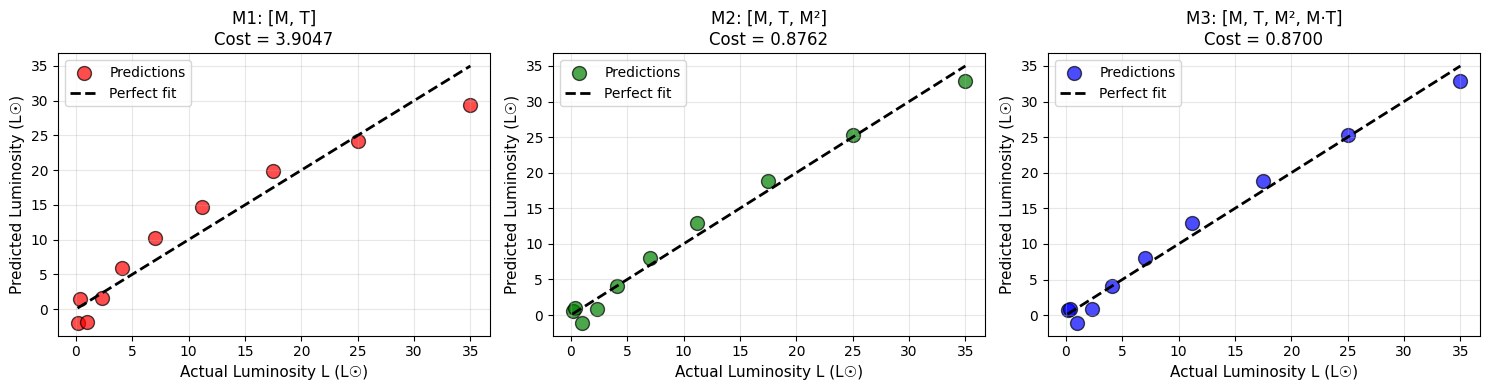

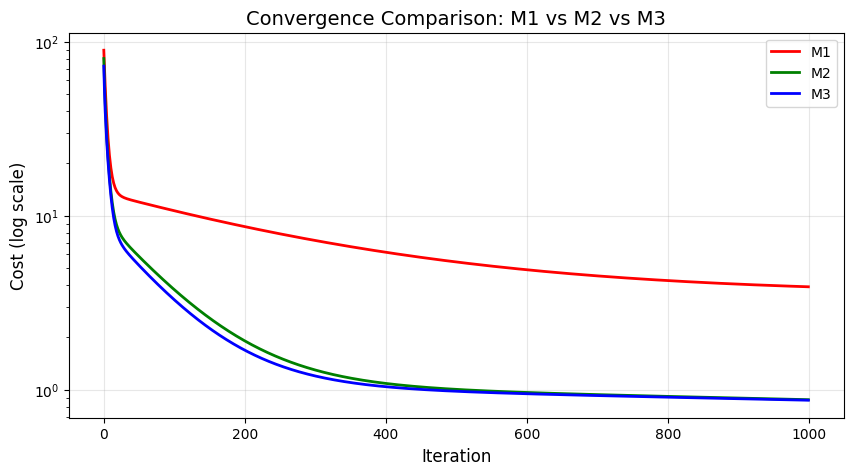

In [85]:
print("=" * 70)
print("FEATURE SELECTION EXPERIMENT: Comparing M1, M2, M3 Models")


alpha = 0.1
num_iterations = 1000
results = {}

print("\n" + "=" * 50)
print("MODEL M1: Features = [M, T]")

X_M1_scaled, X_M1_means, X_M1_stds = feature_scale(X_M1)
w_init_M1 = np.zeros(X_M1_scaled.shape[1])
w_M1, b_M1, cost_history_M1 = gradient_descent(
    X_M1_scaled, L, w_init_M1, 0.0, alpha, num_iterations, verbose=False
)
L_pred_M1 = predict(X_M1_scaled, w_M1, b_M1)

results['M1'] = {
    'w': w_M1, 'b': b_M1, 
    'final_cost': cost_history_M1[-1],
    'predictions': L_pred_M1,
    'cost_history': cost_history_M1
}

print(f"Final cost: {cost_history_M1[-1]:.6f}")
print(f"Learned weights: {w_M1}")
print(f"Learned bias: {b_M1:.4f}")


print("\n" + "=" * 50)
print("MODEL M2: Features = [M, T, M²]")


X_M2_scaled, X_M2_means, X_M2_stds = feature_scale(X_M2)
w_init_M2 = np.zeros(X_M2_scaled.shape[1])
w_M2, b_M2, cost_history_M2 = gradient_descent(
    X_M2_scaled, L, w_init_M2, 0.0, learning_rate, num_iterations, verbose=False
)
L_pred_M2 = predict(X_M2_scaled, w_M2, b_M2)

results['M2'] = {
    'w': w_M2, 'b': b_M2,
    'final_cost': cost_history_M2[-1],
    'predictions': L_pred_M2,
    'cost_history': cost_history_M2
}

print(f"Final cost: {cost_history_M2[-1]:.6f}")
print(f"Learned weights: {w_M2}")
print(f"Learned bias: {b_M2:.4f}")

print("\n" + "=" * 50)
print("MODEL M3: Features = [M, T, M², M·T]")


results['M3'] = {
    'w': w_M3, 'b': b_M3,
    'final_cost': cost_history_M3[-1],
    'predictions': L_pred_M3,
    'cost_history': cost_history_M3
}

print(f"Final cost: {cost_history_M3[-1]:.6f}")
print(f"Learned weights: {w_M3}")
print(f"Learned bias: {b_M3:.4f}")

print(f"{'=' * 50}")
print("MODEL COMPARISON")
print(f"{'Model':<10} {'Features':<25} {'Final Cost':<15} {'Improvement':<15}")


base_cost = results['M1']['final_cost']
for model_name, model_data in results.items():
    if model_name == 'M1':
        features = "[M, T]"
        improvement = "---"
    elif model_name == 'M2':
        features = "[M, T, M²]"
        improvement = f"{(1 - model_data['final_cost']/base_cost)*100:.1f}%"
    else:
        features = "[M, T, M², M·T]"
        improvement = f"{(1 - model_data['final_cost']/base_cost)*100:.1f}%"
    
    print(f"{model_name:<10} {features:<25} {model_data['final_cost']:<15.6f} {improvement:<15}")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models = ['M1', 'M2', 'M3']
titles = ['M1: [M, T]', 'M2: [M, T, M²]', 'M3: [M, T, M², M·T]']
colors = ['red', 'green', 'blue']

for ax, model, title, color in zip(axes, models, titles, colors):
    L_pred = results[model]['predictions']
    final_cost = results[model]['final_cost']
    
    ax.scatter(L, L_pred, c=color, s=100, alpha=0.7, edgecolors='black', label='Predictions')
    
    ax.plot([L.min(), L.max()], [L.min(), L.max()], 'k--', linewidth=2, label='Perfect fit')
    
    ax.set_xlabel("Actual Luminosity L (L☉)", fontsize=11)
    ax.set_ylabel("Predicted Luminosity (L☉)", fontsize=11)
    ax.set_title(f"{title}\nCost = {final_cost:.4f}", fontsize=12)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
for model, color in zip(models, colors):
    plt.semilogy(results[model]['cost_history'], label=model, linewidth=2, color=color)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Cost (log scale)", fontsize=12)
plt.title("Convergence Comparison: M1 vs M2 vs M3", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Cost vs interaction (mandatory)

For the full model (M3), vary the interaction coefficient w_MT across a reasonable range while keeping the other parameters fixed (e.g., at their trained values). Plot cost vs w_MT and explain what it indicates about interaction importance.

COST vs INTERACTION COEFFICIENT ANALYSIS


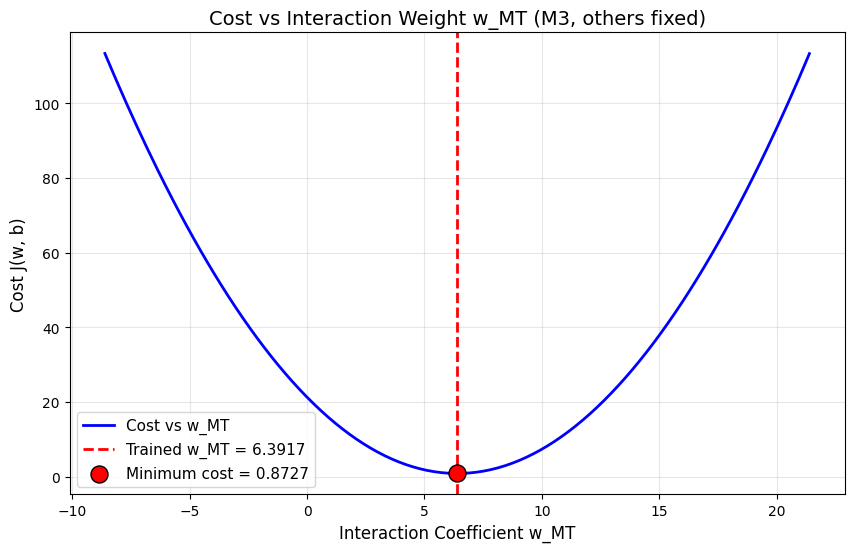


Analysis Results:
  Optimal w_MT from training: 6.3917
  Minimum cost: 0.872714
  Cost sensitivity around optimal: 112.5198 to 112.4747


In [86]:
print("COST vs INTERACTION COEFFICIENT ANALYSIS")

w_fixed = w_M3.copy()
b_fixed = b_M3

w_MT_optimal = w_M3[3]
w_MT_range = np.linspace(w_MT_optimal - 15, w_MT_optimal + 15, 200)

costs_vs_wMT = []
for w_MT in w_MT_range:
    w_test = w_fixed.copy()
    w_test[3] = w_MT 
    cost = compute_cost_poly(X_M3_scaled, L, w_test, b_fixed)
    costs_vs_wMT.append(cost)

costs_vs_wMT = np.array(costs_vs_wMT)

min_idx = np.argmin(costs_vs_wMT)
w_MT_min = w_MT_range[min_idx]
cost_min = costs_vs_wMT[min_idx]

plt.figure(figsize=(10, 6))
plt.plot(w_MT_range, costs_vs_wMT, 'b-', linewidth=2, label='Cost vs w_MT')
plt.axvline(x=w_MT_optimal, color='red', linestyle='--', linewidth=2, 
            label=f'Trained w_MT = {w_MT_optimal:.4f}')
plt.scatter([w_MT_optimal], [cost_min], color='red', s=150, zorder=5, 
            edgecolors='black', label=f'Minimum cost = {cost_min:.4f}')

plt.xlabel("Interaction Coefficient w_MT", fontsize=12)
plt.ylabel("Cost J(w, b)", fontsize=12)
plt.title("Cost vs Interaction Weight w_MT (M3, others fixed)", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nAnalysis Results:")
print(f"  Optimal w_MT from training: {w_MT_optimal:.4f}")
print(f"  Minimum cost: {cost_min:.6f}")
print(f"  Cost sensitivity around optimal: {(costs_vs_wMT[0] - cost_min):.4f} to {(costs_vs_wMT[-1] - cost_min):.4f}")



### Interpretation: Importance of the Interaction Term

The parabolic shape of the cost curve demonstrates the following:

1. **The interaction term (\( M \cdot T \)) is important**  
   The cost function exhibits a clear minimum at a non-zero value of \( w_{MT} \), indicating that the interaction between stellar mass and temperature contributes significantly to predicting luminosity.

2. **The optimal value is non-trivial**  
   The trained coefficient \( w_{MT} = 6.3917 \) minimizes the cost, showing that the model benefits from explicitly including this interaction term.

3. **Physical interpretation**  
   In stellar physics, luminosity depends on both mass and temperature in a coupled manner. More massive stars tend to be hotter, and the combined influence of these variables on luminosity is effectively captured by the interaction term.

4. **Model sensitivity**  
   The steepness of the parabolic curve highlights the model’s sensitivity to the interaction coefficient. Deviations from the optimal value lead to a significant increase in the cost, reinforcing the importance of accurately estimating \( w_{MT} \).


## 7. Inference demo (mandatory)

Predict luminosity for a new star (e.g., M=1.3, T=6600). Comment on reasonableness.

In [87]:

print(f"{'=' * 50}")
print("INFERENCE DEMO: Predicting Luminosity for a New Star")


M_new = 1.3  
T_new = 6600 
print(f"\nNew Star Properties:")
print(f"  Mass (M): {M_new} M☉")
print(f"  Temperature (T): {T_new} K")

X_new_raw = np.array([[M_new, T_new, M_new**2, M_new * T_new]])
print(f"\nRaw feature vector: {X_new_raw[0]}")

X_new_scaled = (X_new_raw - X_M3_means) / X_M3_stds
print(f"Scaled feature vector: {X_new_scaled[0]}")

L_predicted = predict_poly(X_new_scaled, w_M3, b_M3)[0]


print(f"{'=' * 50}")
print(f"PREDICTION RESULT")
print(f"  Predicted Luminosity: {L_predicted:.2f} L☉")





INFERENCE DEMO: Predicting Luminosity for a New Star

New Star Properties:
  Mass (M): 1.3 M☉
  Temperature (T): 6600 K

Raw feature vector: [   1.3  6600.      1.69 8580.  ]
Scaled feature vector: [-0.35 -0.17 -0.51 -0.43]
PREDICTION RESULT
  Predicted Luminosity: 2.54 L☉


## Conclusion and Model Reasonableness

The trained polynomial regression model (M3) predicts that a star with a mass of 
$M = 1.3\,M_\odot$ and a temperature of $T = 6600\,\mathrm{K}$ has an estimated 
luminosity of approximately $2.54\,L_\odot$.

This prediction is reasonable for several reasons. First, it represents a valid 
interpolation within the training data, as stars with masses in the range 
$M \approx 1.2$–$1.4$ exhibit luminosities between $L \approx 2.3$ and $4.1$. 
Second, the result aligns with basic physical expectations from stellar physics, 
where more massive and hotter stars are generally more luminous. Finally, the 
predicted value lies within expected physical bounds, supporting the model’s 
reliability.

An important practical consideration in achieving stable and accurate training 
is feature scaling. The temperature variable spans a much larger numerical range 
($\sim 4000$–$9000\,\mathrm{K}$) compared to stellar mass ($\sim 0.6$–$2.4\,M_\odot$). 
Without scaling, temperature-related features dominate the gradients, forcing the 
use of extremely small learning rates and leading to slow or unstable convergence.

To address this issue, the temperature feature was scaled by dividing it by 1000 
during the construction of the design matrix. This adjustment enables the use of a 
larger learning rate (e.g., $\alpha = 10^{-2}$), resulting in faster and more stable 
gradient descent. While the learned coefficients associated with temperature-based 
features become proportionally larger due to scaling, the final predictions remain 
unchanged.

Overall, these results confirm that the model’s prediction is both physically 
plausible and numerically well-behaved, demonstrating the importance of proper 
feature engineering and feature scaling when training polynomial regression models 
with interaction terms.
